In [142]:
import requests
import sqlite3
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
payload = {"$$app_token":'LzgtLFehgOkMGQIr41ljX5cNJ','$limit':100000}
r =  requests.get('https://data.cityofnewyork.us/resource/6z8x-wfk4.json',payload)

In [ ]:
r= 1

In [2]:
con = sqlite3.connect('eviction.db')

In [3]:
cur = con.cursor()

In [ ]:


'''

TYPES FOR EACH TABLE


court index number STRING
docket number    INTEGER
eviction address STRING
eviction apartment number   STRING
execute date             STRING
marshal first name  STRING
marshal last name   STRING
residential/commercial   STRING
borough  STRING
eviction postcode  NUMBER
ejectment  BINARY (STRING)
eviction/legal posession STRING
latitude INT
longitude INT
community board INT
council district INT
census tract INT
bin INT
bbl INT
nta STRING

'''

In [ ]:
sql_to_create_raw_table = ''' CREATE TABLE raw_data(
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        raw_text text
)
'''

In [ ]:
cur.execute(sql_to_create_raw_table)

In [ ]:
# NEED TO CHANGE THE DICTIONARY INTO TUPLES, CURRENTLY LIST OF DICTIONARIES
store_tuples = []
for row in r.json():
    store_tuples.append((json.dumps(row),))




In [ ]:
cur.executemany('INSERT INTO raw_data (raw_text) VALUES (?)' ,store_tuples)

In [4]:
cur.execute('SELECT  * from raw_data')

In [5]:
rows = cur.fetchall()

In [6]:
#unpack and create a cleaned data table

In [43]:
x,y= rows[0]

In [45]:
y = json.loads(y)

In [54]:
keys_to_look_for = [i for i in y.keys()]

In [55]:
tuples_of_data = []

for row in rows:
    #need to unpack the tuple
    id_number,data = row
    #need to JSONIFY string
    data = json.loads(data)
    #extract values from the dict
    temp_dict = {}
    for key in keys_to_look_for:
        if key in data.keys():
            temp_dict[key] =data[key]
        else:
            temp_dict[key] = 'NaN'
    tuples_of_data.append(tuple(x for x in temp_dict.values()))


In [ ]:
#error encountered, missing K,v Pairs aren't being hit.


In [56]:
tuples_of_data[0]

('66744/18A',
 '082286',
 '605 LIBERTY AVE A/K/ A 252 JEROME STREET',
 '2ND FLOOR',
 '2019-09-23T00:00:00.000',
 'Justin',
 'Grossman',
 'Residential',
 'BROOKLYN',
 '11207',
 'Not an Ejectment',
 'Possession',
 '40.675747',
 '-73.887505',
 '5',
 '37',
 '1170',
 '3088321',
 '3039650030',
 'East New York')

In [18]:
sql_to_create_cleaned_table = ''' CREATE TABLE cleaned_data(
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    court_index_number TEXT,
                    docket_number INTEGER,
                    eviction_address TEXT,
                    eviction_apt_number TEXT,
                    execute_date TEXT,
                    marshal_first_name TEXT,
                    marshal_last_name TEXT,
                    residential_or_commercial TEXT,
                    borough TEXT,
                    eviction_postcode INTEGER,
                    ejectment STRING,
                    eviction_legal_possession TEXT,
                    latitude INTEGER,
                    longitude INTEGER,
                    community_board INTEGER,
                    council_district INTEGER,
                    census_tract INTEGER,
                    bin INTEGER,
                    bbl INTEGER,
                    nta STRING
)
'''

In [17]:
cur.execute('DROP TABLE cleaned_data')

In [19]:
cur.execute(sql_to_create_cleaned_table)

In [57]:
cur.executemany('INSERT INTO cleaned_data (court_index_number,docket_number,eviction_address,eviction_apt_number,execute_date,marshal_first_name,marshal_last_name,residential_or_commercial,borough,eviction_postcode,ejectment,eviction_legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)',tuples_of_data)

In [58]:
con.commit()

In [59]:
cur.execute('SELECT * FROM cleaned_data')

In [60]:
x =  cur.fetchall()

In [62]:
con.close()

In [66]:
def return_by_borough(borough):
    con = sqlite3.connect('eviction.db')
    cur = con.cursor()
    cur.execute('SELECT * FROM cleaned_data where borough=:placeholder',{'placeholder':borough})
    return cur.fetchall()

In [67]:
return_by_borough('QUEENS')

[(9,
  '50825/16',
  4406,
  '188-29 KEESEVILLE AVENUE',
  'NaN',
  '2017-04-18T00:00:00.000',
  'Edward',
  'Guida',
  'Residential',
  'QUEENS',
  11412,
  'Not an Ejectment',
  'Possession',
  40.699116,
  -73.765814,
  12,
  27,
  400,
  4221856,
  4104270035,
  'St. Albans'),
 (13,
  '71606/16',
  4928,
  '101-33 132ND ST. BSMT.',
  'BSMT',
  '2017-03-17T00:00:00.000',
  'Robert',
  'Renzulli',
  'Residential',
  'QUEENS',
  11419,
  'Not an Ejectment',
  'Possession',
  'NaN',
  'NaN',
  'NaN',
  'NaN',
  'NaN',
  'NaN',
  'NaN',
  'NaN'),
 (15,
  '51764/19',
  94151,
  '97-15 HORACE HARDING  EXPWY.',
  '2O',
  '2019-04-15T00:00:00.000',
  'Henry',
  'Daley',
  'Residential',
  'QUEENS',
  11368,
  'Not an Ejectment',
  'Possession',
  40.734938,
  -73.862399,
  4,
  21,
  455,
  4047333,
  4019180105,
  'Corona'),
 (21,
  '50834/17*',
  292011,
  '84-49 168 STREET',
  '2S',
  '2017-07-10T00:00:00.000',
  'George',
  'Essock',
  'Residential',
  'QUEENS',
  11432,
  'Not an Eject

In [68]:
table_of_queens = return_by_borough('QUEENS')

In [74]:
keys_to_look_for.insert(0,'id')

In [75]:
df = pd.DataFrame(table_of_queens,columns=keys_to_look_for)

In [82]:
df = df.drop(labels='id',axis=1)

In [87]:
sorted_by_date = df.sort_values(by='executed_date')

In [90]:
sorted_by_date

,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip,ejectment,eviction_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
12294,67408/16,6719,119-01 GUY BREWER BOULEVARD,NaN,2017-01-03T00:00:00.000,Edward,Guida,Residential,QUEENS,11434,Not an Ejectment,Possession,40.68249,-73.781957,12,27,284,4267704,4123580029,Baisley Park
9977,79485/15,7075,142-27 HOOKCREEK BLVD,NaN,2017-01-03T00:00:00.000,Edward,Guida,Residential,QUEENS,11422,Not an Ejectment,Possession,40.661436,-73.728659,13,31,656,4533799,4136270067,Rosedale
1433,71508/16,6820,91-18 195TH STREET,B3,2017-01-03T00:00:00.000,Edward,Guida,Residential,QUEENS,11423,Not an Ejectment,Possession,40.712903,-73.765971,12,27,500,4434695,4108210046,Hollis
7345,60777/16,4214,120-54 222ND STREET,NaN,2017-01-03T00:00:00.000,Edward,Guida,Residential,QUEENS,11411,Not an Ejectment,Possession,40.688316,-73.741653,13,27,610,4276009,4128020183,Cambria Heights
2172,65795/15,1117,119-55 FARMERS BLVD. A/K/A 11955 FARMERS BLVD.,NaN,2017-01-03T00:00:00.000,Edward,Guida,Residential,QUEENS,11412,Not an Ejectment,Possession,40.686915,-73.761364,12,27,394,4272483,4126440043,St. Albans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6732,306411/21,21566,104-14 LEFFERTS BLVD,BSMT,2022-03-31T00:00:00.000,George,"Essock, Jr.",Residential,QUEENS,11419,Not an Ejectment,Possession,40.685946,-73.824042,10,28,106,4204191,4095720011,South Ozone Park
1793,55586/20,105938,91-59 191ST STREET,1F,2022-04-01T00:00:00.000,Henry,Daley,Residential,QUEENS,11423,Not an Ejectment,Possession,40.712198,-73.768456,12,27,500,4231483,4108200001,Hollis
8852,305124/21,21562,110-60 DUNKIRK ST. ALL RMS.OF THE SOUTH,NaN,2022-04-04T00:00:00.000,George,"Essock, Jr.",Commercial,QUEENS,11412,Not an Ejectment,Possession,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,303492/21,27977,155-45 LINDEN BOULEVARD,NaN,2022-04-05T00:00:00.000,Edward,Guida,Commercial,QUEENS,11434,Not an Ejectment,Possession,40.687182,-73.791803,12,28,270,4263829,4121720059,South Jamaica


In [104]:
df.groupby(pd.Grouper(key='executed_date',axis=0,freq='M'))

In [102]:
df['executed_date'] = pd.to_datetime(df['executed_date'])

In [103]:
df

,court_index_number,docket_number,eviction_address,eviction_apt_num,executed_date,marshal_first_name,marshal_last_name,residential_commercial_ind,borough,eviction_zip,ejectment,eviction_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta
0,50825/16,4406,188-29 KEESEVILLE AVENUE,NaN,2017-04-18,Edward,Guida,Residential,QUEENS,11412,Not an Ejectment,Possession,40.699116,-73.765814,12,27,400,4221856,4104270035,St. Albans
1,71606/16,4928,101-33 132ND ST. BSMT.,BSMT,2017-03-17,Robert,Renzulli,Residential,QUEENS,11419,Not an Ejectment,Possession,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51764/19,94151,97-15 HORACE HARDING EXPWY.,2O,2019-04-15,Henry,Daley,Residential,QUEENS,11368,Not an Ejectment,Possession,40.734938,-73.862399,4,21,455,4047333,4019180105,Corona
3,50834/17*,292011,84-49 168 STREET,2S,2017-07-10,George,Essock,Residential,QUEENS,11432,Not an Ejectment,Possession,40.714678,-73.797038,8,24,454,4210898,4098590088,Briarwood-Jamaica Hills
4,Q52397/18A,107152,816 SENECA AVENUE,6,2018-07-31,Darlene,Barone,Residential,QUEENS,11385,Not an Ejectment,Possession,40.701325,-73.905195,5,34,551,4082743,4034610037,Ridgewood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13353,Q69763/18,92967,69-65 73RD PLACE,BASEMENT UNIT,2019-03-29,Ileana,Rivera,Residential,QUEENS,11379,Not an Ejectment,Possession,40.707694,-73.877644,5,30,619,4092066,4037900026,Middle Village
13354,76798/17,15925,1934 PUTNAM AVENUE,1R,2018-07-02,Edward,Guida,Residential,QUEENS,11385,Not an Ejectment,Possession,40.703955,-73.902945,5,30,585,4083337,4034820023,Ridgewood
13355,52383/17,109214,90-50 170 ST AKA 169-19-21-23 JAMAICA,3,2017-10-03,Maxine,Chevlowe,Residential,QUEENS,11432,Not an Ejectment,Possession,40.707993,-73.790241,12,27,460,4209700,4098020001,Jamaica
13356,79885/17,76168,42-70 156TH STREET,3AL,2018-03-21,Justin,Grossman,Residential,QUEENS,11355,Not an Ejectment,Possession,40.759478,-73.80977,7,20,1187,4121548,4053860020,East Flushing


In [136]:
df.groupby(pd.Grouper(key='executed_date',axis=0,freq='M')).groups.values()

dict_values([420, 737, 1167, 1514, 1915, 2323, 2673, 3074, 3411, 3783, 4097, 4325, 4730, 5112, 5547, 5935, 6333, 6684, 7135, 7565, 7937, 8267, 8561, 8777, 9232, 9577, 9965, 10309, 10657, 10958, 11294, 11580, 11850, 12095, 12343, 12482, 12819, 13061, 13186, 13186, 13186, 13186, 13186, 13186, 13186, 13186, 13187, 13188, 13189, 13189, 13190, 13190, 13190, 13192, 13195, 13201, 13204, 13210, 13219, 13224, 13249, 13283, 13354, 13358])

In [129]:
list_of_dates = []
for key in df.groupby(pd.Grouper(key='executed_date',axis=0,freq='M')).groups.keys():
    list_of_dates.append(key)

In [137]:
list_of_values = []
for counter,value in enumerate(df.groupby(pd.Grouper(key='executed_date',axis=0,freq='M')).groups.values()):
    if counter == 0:
        list_of_values.append(value)
    else:
        list_of_values.append(value-sum(list_of_values))

In [138]:
list_of_values

[420,
 317,
 430,
 347,
 401,
 408,
 350,
 401,
 337,
 372,
 314,
 228,
 405,
 382,
 435,
 388,
 398,
 351,
 451,
 430,
 372,
 330,
 294,
 216,
 455,
 345,
 388,
 344,
 348,
 301,
 336,
 286,
 270,
 245,
 248,
 139,
 337,
 242,
 125,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 3,
 6,
 3,
 6,
 9,
 5,
 25,
 34,
 71,
 4]

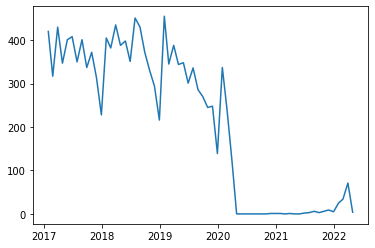

In [143]:
plt.plot(list_of_dates,list_of_values)

In [144]:
con.close()